# Important Equations:
## Work:
The equation for the work done in the system can be found as:
$$W = - \int_{V_i}^{V_f}P(V)dV$$
Where the equation for pressure is:
$$P = \frac{nRT}{V}$$
Meaning work can be written as:
$$W = - nRT \int_{V_i}^{V_f} \frac{dV}{V}$$
$$W = nRT(ln(\frac{V_i}{V_f}))$$
When considering changes in temperature, the equation becomes:
$$\Delta W = nR(T_i - T_f)ln(V_i/V_f)$$
## Heat Conduction:
Fourier Heat Conduction Law can be used to find the conductivity of a material:
$$\frac{Q}{\Delta t}=-k_{t}A\frac{\Delta T}{\Delta x}$$
Where:
$\frac{Q}{\Delta t}$ is the rate of exchange of heat between sensors (In W, or J/S),
$k_T$ is the coefficient of thermal conductivity,
$A$ is the cross-sectional surface area between sensors (in $m^2$),
$\Delta T$ is the difference in temperature between sensors, $T_2 - T_1$ (in K), and
$\Delta x$ is the distance between the sensors (in m).

Thankfully, the power that the engine operates at is given by the product documentation as approximately 1 W, meaning that we can solve for the coefficient of thermal conductivity as:
$$k_t = - \frac{\Delta x}{\Delta T}\frac{1}{A}$$

## Efficiency:
The efficiency of the system can be found as:
$$\eta = \frac{T_f - T_i}{T_f + \frac{C_V (T_f - T_i)}{nR ln(V_f/V_i)}}$$
Where $C_V$ is:
$$C_V = \frac{nRf}{2}$$
Meaning $\eta$ can be rewritten as:
$$\eta = \frac{T_f - T_i}{T_f + \frac{f}{2}\frac{T_f - T_i}{ln(V_f/V_i)}}$$

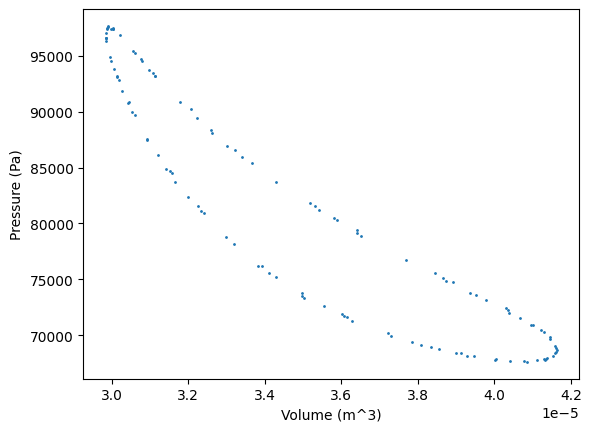

In [33]:
# Load data in dfs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

df_1 = pd.read_csv("run1.csv", header=0, 
                   names=["time", "angle", "volume", "pressure","temp1", "temp2"])

time = df_1["time"]/1000 # s
radians = df_1["angle"]
volume = df_1["volume"] / 1000000 # m^3
pressure = df_1["pressure"] * 1000 # Pa
temp1 = df_1["temp1"] + 273.15 # K
temp2 = df_1["temp2"] + 273.15 # K

plt.scatter(volume, pressure, s=1)
plt.xlabel("Volume (m^3)")
plt.ylabel("Pressure (Pa)")
plt.show()

# Finding the Coefficient of Conductivity:

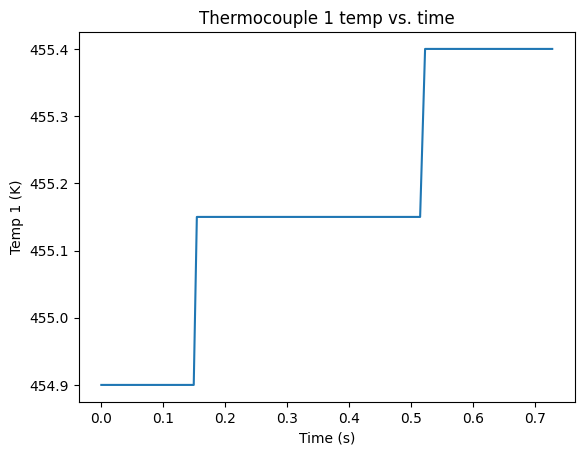

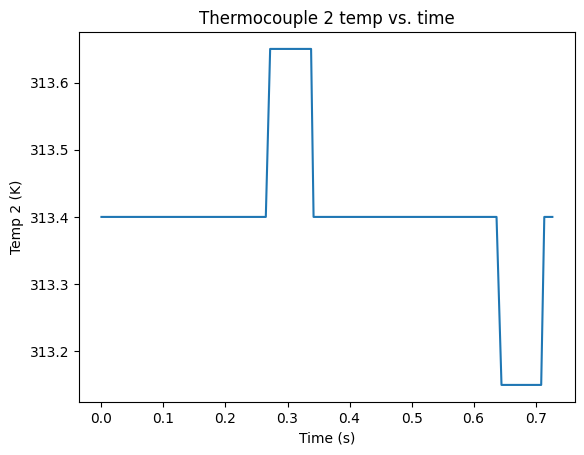

Thermocouple 2 had a temperature of 313.65 K at 0.27 s
At the same time, thermocouple 1 had a temperature of 455.15 K.
This gives a value for Delta T of -141.50 K


In [36]:
# finding deltas t and T
plt.plot(time, temp1)
plt.xlabel(f'Time (s)')
plt.ylabel(f'Temp 1 (K)')
plt.title('Thermocouple 1 temp vs. time')
plt.show()
plt.plot(time, temp2)

plt.xlabel(f'Time (s)')
plt.ylabel(f'Temp 2 (K)')
plt.title('Thermocouple 2 temp vs. time')
plt.show()

temp2_max = max(temp2)
temp2_index = temp2.idxmax()
time_temp2_max = time[temp2_index]
print(f'Thermocouple 2 had a temperature of {temp2_max:.2f} K at {time_temp2_max:.2f} s')
print(f'At the same time, thermocouple 1 had a temperature of {temp1[temp2_index]:.2f} K.')
delta_T = temp2_max -temp1[temp2_index]
print(f'This gives a value for Delta T of {delta_T:.2f} K')

The remaining variables to be able to find the conductivity are then the cross sectional areas shared by the glass and air as well as the distance between the couples. 

The couples are rougly 8cm apart, or 0.08 m.

Assuming the glass has a thickness of 1mm and the thermocouple has a diameter of 5mm, that would mean the glass has a cross sectional surface area of $5mm^2$ or $5x10^{-6}m^2$.

The documentation for the engine says that the change in volume caused by the piston is $12cm^3$ ($1.2 x 10^{-5} m^3$), and that the path of the piston is 24mm (0.024m) long. As it traces out a cylinder, this means that we can use $V = \pi r^2 h$ where h is the length of the path to find $r=\sqrt{\frac{V}{\pi h}} = \sqrt{\frac{1.2e-5 m^3}{\pi 0.024 m}}=1.26x10^{-2} m$, meaning the additional area, $A=\pi r^2$ is equal to $4.99x10^{-4}m^2$

This gives a total cross sectional area of $5.04x10^{-4}m^2$.

In [37]:
k_engine = -(4e-2/5.04e-4)/delta_T
print(k_engine)

0.5608839531101015


In [38]:
def work(v_i, v_f, p_i, p_f, t_i, t_f):
    R = 8.314
    n_i = (p_i * v_i) / (R * t_i)
    n_f = (p_f * v_f) / (R * t_f)
    avg_n = (n_i + n_f)/2
    delta_T = t_i - t_f
    delta_w = avg_n * R * delta_T * np.log(v_i/v_f)
    print(f"n is roughly {avg_n:.2e} mols")
    return delta_w

def pressure_function(v, T, n):
    R = 8.314
    pressure = (n * R * T)/v
    return pressure

def find_values(vol_data, press_data, estimates):
    popt, pcov = curve_fit(pressure_function, vol_data, press_data, p0=estimates)
    return popt, pcov

In [41]:
# kPa -> Pa
p_i = max(pressure)
p_f = min(pressure)

index_i = pressure.idxmax()
index_f = pressure.idxmin()

v_i = volume.loc[index_i]
v_f = volume.loc[index_f]

t1_i = temp1.loc[index_i]
t1_f = temp1.loc[index_f]

t2_i = temp2.loc[index_i]
t2_f = temp2.loc[index_f]

print(f'Max pressure: {p_i:.2f} Pa, Volume: {v_i:.2e} m^3')
print(f"Temp1: {t1_i:.2f} K")
print(f"Temp2: {t2_i:.2f} K")
print(f'Min pressure: {p_f:.2f} Pa, Volume: {v_f:.2e} m^3')
print(f"Temp1: {t1_f:.2f} K")
print(f"Temp2: {t2_f:.2f} K")

delta_w = work(v_i, v_f, p_i, p_f, t1_i, t1_f)
print(f'{delta_w:.2e}')

Max pressure: 97663.57 Pa, Volume: 2.99e-05 m^3
Temp1: 454.90 K
Temp2: 313.40 K
Min pressure: 67622.07 Pa, Volume: 4.09e-05 m^3
Temp1: 455.40 K
Temp2: 313.15 K
n is roughly 7.51e-04 mols
9.73e-04


Temp = 12052.55 +/- 9.83e+17
n = 0.02703328536874454 +/- 2.21e+12


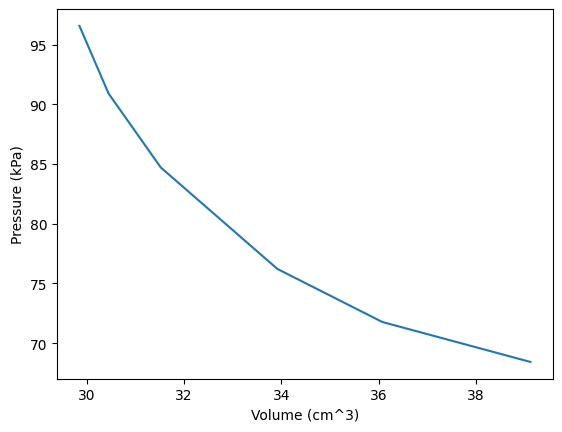

In [42]:
# Finding lower and higher regions to fit curve
lower_region = df_1[9:15]
lower_pressure = lower_region['pressure'].values
lower_volume = lower_region['volume'].values

t_est = 454
n_est = 9.73e-4

popt, pcov = find_values(lower_volume, lower_pressure, [t_est, n_est])

temp, n = popt
sigma_temp, sigma_n = np.sqrt(np.diag(pcov))

print(f'Temp = {temp:.2f} +/- {sigma_temp:.2e}')
print(f"n = {n} +/- {sigma_n:.2e}")

plt.plot(lower_volume, lower_pressure)
plt.xlabel("Volume (cm^3)")
plt.ylabel("Pressure (kPa)")
plt.show()